In [1]:
import os; # os.environ['ACCELERATE_DISABLE_RICH'] = "1"
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional, Union, List, Tuple, Callable, Any

from dataclasses import dataclass, replace
import numpy as np
import einops
from tqdm.notebook import trange

import pandas as pd
from functools import reduce

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from my_plotly_utils import imshow, line, hist, scatter, bar

from custom_plots import *
from model_setup import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
config = Config(
    n_features = 5,
    n_hidden = 2,
    n_instances = 10,
)

importance = torch.ones(config.n_features)
importance[0] = 10
feature_probability = 0.06*torch.ones(config.n_instances)
model = BasicMLP(
    config=config,
    device=DEVICE,
    importance = importance[None, :],
    feature_probability = feature_probability[:, None]
)

optimize(model,
         steps=10_000,
         batch_fn=Model.generate_batch_rand,
         loss_fn=Model.mse_loss,
         lr=1e-3,
         )
# model.load_state_dict(torch.load('models/MSE_f5_h2_p03_imp101.pt'))
print('Importance:', model.importance)
print('Feature probability:', model.feature_probability.T)

  0%|          | 0/10000 [00:00<?, ?it/s]

Importance: Parameter containing:
tensor([[10.,  1.,  1.,  1.,  1.]], device='cuda:0')
Feature probability: tensor([[0.0600, 0.0600, 0.0600, 0.0600, 0.0600, 0.0600, 0.0600, 0.0600, 0.0600,
         0.0600]], device='cuda:0')


[('Feat 0', 'k'), ('Feat 1', 'r'), ('Feat 2', 'b'), ('Feat 3', 'g'), ('Feat 4', 'm')]


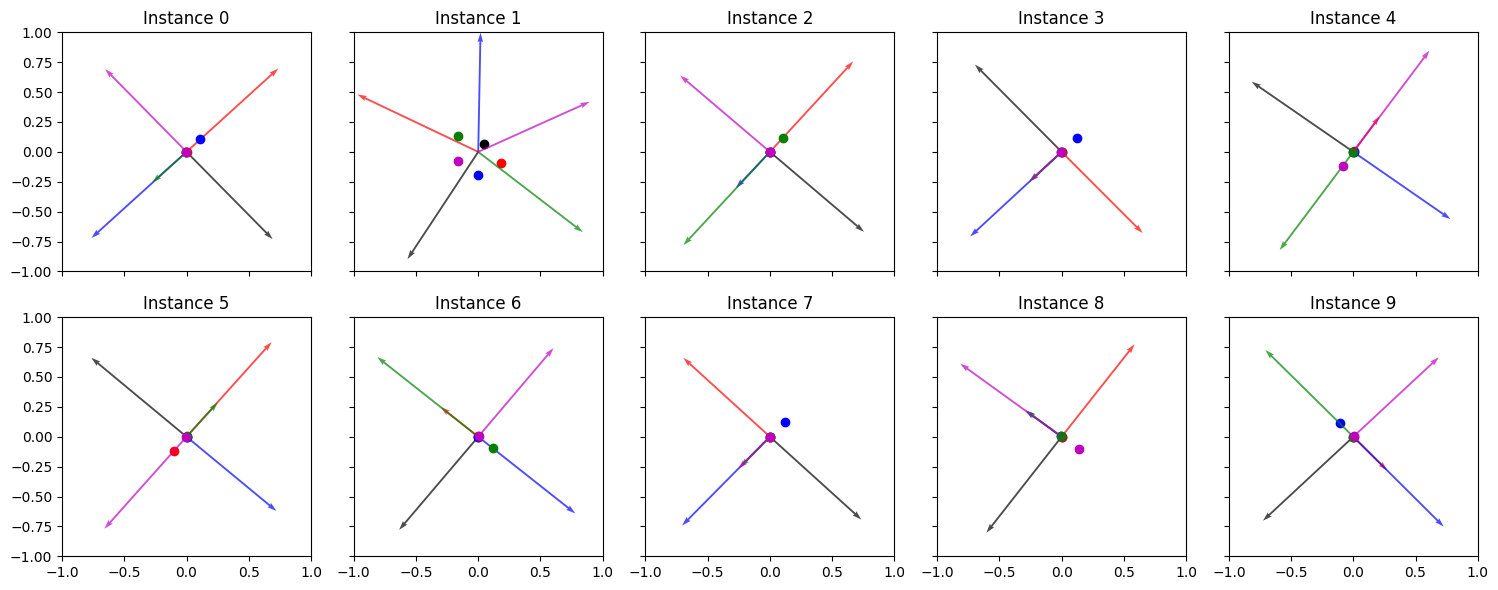

In [18]:
plot_hidden_2D(model)

In [50]:
batch, target = model.generate_batch_rand(4*4096)
loss_by_inst = model.mse_loss(model(batch), target)
bar(loss_by_inst, labels=dict(x='Model Instance', y='Loss'))

In [51]:
b = model.b_final.clone().detach()
line([b[i] for i in range(10)], title='Bias by feature', labels=dict(index='Feature', value='Bias'),
     names=[f'Instance {i}' for i in range(10)])

In [53]:
feature_prob = torch.logspace(np.log10(0.01), np.log10(0.5), 9).to(DEVICE)
batch = torch.stack([model.generate_batch_rand(4096*5, feature_probability=p)[0]
                     for p in feature_prob], dim=1)
out = model(batch)
loss_per_feature = model.mse_loss_unweighted(out, batch, per_feature=True)
mean_loss_per_feature = loss_per_feature.mean(0)

line([l for l in mean_loss_per_feature[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
     title=f'MSE loss per feature (instance {instance})', names=[f'Feature prob: {p:.2f}' for p in feature_prob])

In [22]:
num_active_features = (batch > 0).sum(-1, keepdim=True).expand(batch.shape)
zero_active = (num_active_features == 0).float()
one_active = (num_active_features == 1).float()
more_active = (num_active_features > 1).float()

loss_zero_active = (loss_per_feature*zero_active).sum(0)/zero_active.sum(0)
loss_one_active = (loss_per_feature*one_active).sum(0)/one_active.sum(0)
loss_more_active = (loss_per_feature*more_active).sum(0)/more_active.sum(0)

# loss_active = loss_active/loss_active[..., 0:1]
# loss_not_active = loss_not_active/loss_not_active[..., 0:1]
# print(loss_active.shape, loss_not_active.shape)

line([l for l in loss_zero_active[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
     title=f'(Zero active features) MSE loss per feature (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])
line([l for l in loss_one_active[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
     title=f'(One active feature) MSE loss per feature (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])
line([l for l in loss_more_active[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
     title=f'(One+ active features) MSE loss per feature (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])

In [54]:

# noise_std = torch.tensor([0.1]).to(DEVICE)
noise_std = torch.logspace(np.log10(0.01), np.log10(1), 9).to(DEVICE)
batch, target = batch_together(model.generate_batch_rand, reps=len(noise_std), n_batch=4096*5)
out = model.run_with_noise(batch, noise_std)
loss_per_feature = model.mse_loss_unweighted(out, target, per_feature=True).mean(0)

# line([l for l in (loss_per_feature[:, instance] - loss_per_feature[0, instance])], labels=dict(index='Feature', value='Loss',),
#      title=f'MSE loss per feature (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])
# loss_per_feature = loss_per_feature/loss_per_feature[..., 0:1]
# loss_per_feature.shape
line([l for l in loss_per_feature[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
     title=f'MSE loss per feature (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])

In [56]:
import numpy as np
# noise_std = torch.tensor([0.1]).to(DEVICE)
noise_std = torch.logspace(np.log10(0.01), np.log10(1), 9).to(DEVICE)
batch, target = batch_together(model.generate_batch_rand, reps=len(noise_std), n_batch=4096*5)
out = model.run_with_noise(batch, noise_std)
loss_per_feature = model.mse_loss_unweighted(out, target, per_feature=True)
num_active_features = (batch > 0).sum(-1, keepdim=True).expand(batch.shape)
zero_active = (num_active_features == 0).float()
one_active = (num_active_features == 1).float()
more_active = (num_active_features > 1).float()

loss_zero_active = (loss_per_feature*zero_active).sum(0)/zero_active.sum(0)
loss_one_active = (loss_per_feature*one_active).sum(0)/one_active.sum(0)
loss_more_active = (loss_per_feature*more_active).sum(0)/more_active.sum(0)

# loss_active = loss_active/loss_active[..., 0:1]
# loss_not_active = loss_not_active/loss_not_active[..., 0:1]
# print(loss_active.shape, loss_not_active.shape)

line([l for l in loss_zero_active[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
     title=f'(Zero active features) MSE loss per feature (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])
line([l for l in loss_one_active[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
     title=f'(One active feature) MSE loss per feature (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])
line([l for l in loss_more_active[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
     title=f'(One+ active features) MSE loss per feature (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])
     

# line([l for l in loss_active[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
#      title=f'(At least a feature active) MSE loss per feature as percentage of feauture 0 loss (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std])
# line([l for l in loss_not_active[:, instance]], labels=dict(index='Feature', value='Loss',), log_y=True,
#      title=f'(No feature active) MSE loss per feature as percentage of feauture 0 loss (instance {instance})', names=[f'Noise std: {s:.2f}' for s in noise_std[:]])

In [60]:
loss_zero_active_all = (loss_per_feature*zero_active).mean(0).sum(-1)
loss_one_active_all = (loss_per_feature*one_active).mean(0).sum(-1)
loss_more_active_all = (loss_per_feature*more_active).mean(0).sum(-1)

fig = bar(torch.zeros_like(loss_zero_active_all[:, instance]), return_fig=True, labels=dict(x='Noise std level (see prev plot)', y='Loss',),
          title='Loss by number of active features (over all features)')
fig.add_trace(go.Bar(y=loss_zero_active_all[:, instance].detach().cpu().numpy(), name='Zero active'))
fig.add_trace(go.Bar(y=loss_one_active_all[:, instance].detach().cpu().numpy(), name='One active'))
fig.add_trace(go.Bar(y=loss_more_active_all[:, instance].detach().cpu().numpy(), name='More than one active'))

In [45]:
loss_active_all_feat = loss_active[..., 0]
loss_not_active_all_feat = loss_not_active[..., 0]

fig = bar(loss_active_all_feat[:, instance], return_fig=True, labels=dict(x='Noise std level (see prev plot)', y='Loss'),
          title='Loss by whether at least one feature is active (only feature 0)')
fig.add_trace(go.Bar(y=loss_not_active_all_feat[:, instance].detach().cpu().numpy(), name='Not active'))

In [59]:
fig = bar(torch.zeros_like(mean_positive_interference[instance]), labels=dict(x='Feature', y='Feature interference/bias',), 
          title='Maximum projected feature/2 vs negative bias ', return_fig=True)
fig.add_trace(go.Bar(y=mean_positive_interference[instance].cpu().numpy(), name='Max positive interference'))
fig.add_trace(go.Bar(y=-b[instance].cpu().numpy(), name='Negative of bias'))
fig.update_layout(barmode='group').show()

In [58]:
W = model.W.detach().clone()
b = model.b_final.detach().clone()

batch, target = model.generate_batch_rand(4096*2)
loss_by_feature = model.mse_loss_unweighted(model(batch), target, per_feature=True).mean(0)
# print(loss_by_feature.shape)

interference = torch.einsum('ifh,igh->ifg', W, W)
interference[:, torch.arange(model.config.n_features), torch.arange(model.config.n_features)] = 0
pos_interference_dummy = (interference > 0).float()
mean_positive_interference = (interference*pos_interference_dummy).max(-1).values/2

bar(mean_positive_interference[instance], labels=dict(x='Feature', y='Mean positive interference',))
bar(-b[instance], labels=dict(x='Feature', y='Bias',))

In [117]:
cfg = model.config
W = model.W.detach()
W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

interference = torch.einsum('ifh,igh->ifg', W_norm, W)
interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
net_interference = (interference**2 * model.feature_probability[:, None, :]).sum(-1).cpu()

In [63]:
plot_noise_curves(model, noise_std=torch.linspace(0, 2, 1), model_idx=instance).show()

torch.Size([500, 1, 10, 5]) torch.Size([500, 1, 10, 5])


In [126]:
batch, target = model.generate_batch_rand(4096*2)
loss_by_feature = model.mse_loss_unweighted(model(batch), target, per_feature=True).mean(0)
print(loss_by_feature.shape)

my_interference = torch.einsum('ifh,igh->ifg', W, W)
my_interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0
my_net_interference = (my_interference.clamp(min=0).pow(2) * model.feature_probability[:, None, :]).sum(-1)
fig1 = line(my_net_interference[instance], return_fig=True)
fig2 = line(loss_by_feature[instance], return_fig=True)
figs_to_subplots([fig1, fig2], return_fig=True, title='Positive Expected interference (left) vs Empirically calculated loss per feature (right) (for instance 6)',
                 xaxis='Feature', yaxis='Loss/Interference').show()

torch.Size([10, 5])


In [125]:
fig1 = line(my_net_interference.mean(0), return_fig=True)
fig2 = line(loss_by_feature.mean(0), return_fig=True)
figs_to_subplots([fig1, fig2], return_fig=True, title='Positive Expected interference (left) vs Empirically calculated loss per feature (right) (avg on 10 instances)',
                 xaxis='Feature', yaxis='Loss/Interference').show()

In [123]:
line(net_interference[6], labels=dict(y='TMS Interference', x='Feature'))

In [124]:
line(b[6], labels=dict(y='Bias', x='Feature'))

In [52]:
W = model.W.clone().detach()
b = model.b_final.clone().detach()

line([b_i for b_i in b])

In [50]:
# plot_noise_curves2(model,
#                   noise_std=torch.linspace(0, 1, 5).to(DEVICE),
#                   model_idx=1,
# )

In [89]:
W = model.W.detach()
b = model.b_final.detach()

W_norm = W / (1e-5 + W.norm(dim=-1, keepdim=True))
cos_sim = einops.einsum(W, W_norm, 'i f1 h,i f2 h-> i f1 f2')
imshow(cos_sim, title='Cosine similarity between features', facet_col=0, facet_col_wrap=5)

In [53]:
imshow(b)

In [58]:
plot_noise_curves(model,
                  noise_std=torch.tensor([0]).to(DEVICE),
                  model_idx='avg',
)

torch.Size([500, 1, 10, 10]) torch.Size([500, 1, 10, 10])


In [76]:
def plot_noise_curves2(model: Model, 
                      noise_std: Float[Tensor, 'noise'] = None,
                      model_idx: Union[Literal['avg'], int] = 'avg', 
                      batch_size: int = 500):
    device = model.config.device
    if noise_std is None:
        noise_std = torch.linspace(0, 2, 10, device=device)

    # batch [batch_size, noise, n_instances, n_features]
    batch, target = batch_together(model.generate_batch_rand, reps=len(noise_std), n_batch=batch_size)

    # batch, target = torch.zeros_like(batch), torch.zeros_like(target)

    out = model.run_with_noise(batch, noise_std=noise_std)    
    # loss = model.accuracy(out, target, per_feature=True) # [noise, n_instances, n_features]
    loss = accuracy(0, out, target, per_feature=True) # [noise, n_instances, n_features]
    print(loss.shape)
    if model_idx == 'avg':
        loss = loss.mean(1)
        fig = line([l for l in loss],
             title=f'Loss per feature with Gaussian noise on hidden space (avg over {model.config.n_instances} models)',
             color_discrete_sequence=px.colors.sequential.Viridis,
             yaxis_title='Loss', xaxis_title='Feature', return_fig=True)
    else:
        loss = loss[:, model_idx]
        fig = line([l for l in loss],
            title=f'Loss per feature with Gaussian noise on hidden space (model {model_idx})',
            color_discrete_sequence=px.colors.sequential.Viridis,
            yaxis_title='Loss', xaxis_title='Feature', return_fig=True)
    
    return fig

# Archive

In [87]:
batch, labels = model.generate_batch_rand(1000)
noise_levels = torch.linspace(0, 10, 10, device=DEVICE)
out = model.run_with_noise(batch, noise_std=noise_levels)
# labels = einops.repeat(labels, 'b i -> n b i', n=len(noise_levels))
labels = einops.repeat(labels, 'b i f -> n b i f', n=len(noise_levels))
# loss = model.mse_loss_unweighted(out, labels, per_feature=True) # shape [noise_std, n_instances, n_features]
# print('Labels', labels.shape)
print('Out', out.shape)
# print('Loss', loss.shape)

accuracy = model.accuracy(out.transpose(0, 1), labels.transpose(0, 1), per_feature=True)
print('Accuracy', model.accuracy(out.transpose(0, 1), labels.transpose(0, 1)))

line([l for l in (accuracy).mean(0).mean(1)], title=f'Loss per feature from different noise levels (avg over 10 models)', 
       color_discrete_sequence=px.colors.sequential.Viridis,
       yaxis_title='Loss', xaxis_title='Feature', names=[f'Noise std {n:.2f}' for n in noise_levels])

Out torch.Size([10, 1000, 10, 5])
Accuracy tensor(0.2711, device='cuda:0')


In [13]:
batch, labels = model.generate_batch_one_hot_noiseless(5)
out = model(batch)
# out = F.softmax(out, dim=-1)
imshow(out, title='Model prediction for one-hot features', facet_col=1, facet_col_wrap=5,
       facet_labels=[f'({i}) Feat Prob: {p:.3f}' for i, p in enumerate(feature_probability)], labels={'animation_frame': 'Noise level'})

In [23]:
instance = 8
W, b = model.W.detach(), model.b_final.detach()
# x, y, z = W[instance].unbind(-1)
x, y = W[instance].unbind(-1)
scatter(x, y, color=np.arange(len(x)), height=500, width=500,
title='Feature representation in hidden activations', labels={'color': 'Importance'})
bar(b[instance], title='Bias for output features', labels={'x': 'Feature', 'y': 'Bias'})

In [81]:
sparsity_mult = torch.linspace(1, 2, 10, device=DEVICE)
group_batch = [model.generate_batch_one_hot(10000, feature_probability=m*model.feature_probability)
               for m in sparsity_mult]
batch, labels = torch.stack([b[0] for b in group_batch]), torch.stack([l[1] for l in group_batch])
out = model(batch)

instance = 6
feat_p = model.feature_probability[instance].item()

loss = model.cross_entropy_loss_unweighted(out, labels, per_feature=True).mean(1) # shape [noise_std, n_instances, n_features]
line([l for l in (loss)[:, instance, :-1]], title=f'Loss per feature from different noise levels (feature prob {feat_p:.2f})', 
       color_discrete_sequence=px.colors.sequential.Viridis,
       yaxis_title='Loss', xaxis_title='Feature', 
       names=[f'feat prob {feat_p*m:.2f}' for m in sparsity_mult])

batch, labels = model.generate_batch_one_hot_noiseless()
out = model(batch)
# out = F.softmax(out, dim=-1)
imshow(out, title='Model prediction for one-hot features', facet_col=1, facet_col_wrap=5,
       facet_labels=[f'Feat Prob: {p:.3f}' for p in feature_probability], labels={'animation_frame': 'Noise level'})


In [71]:

# batch, labels = model.generate_batch_one_hot(10)
# out = model(batch)
# loss = model.cross_entropy_loss_unweighted(out, labels) # shape [n_batch, n_instances, n_features]
# in_vs_out = torch.stack([batch, F.softmax(out, dim=-1)], dim=1)
# imshow(in_vs_out, title='Model prediction vs input', animation_frame=0, facet_col=1)

# W, b = model.W.detach(), model.b_final.detach()
# # x, y, z = W[instance].unbind(-1)
# x, y = W[instance].unbind(-1)
# scatter(x, y, color=np.arange(len(x)), height=500, width=500,
# title='Feature representation in hidden activations', labels={'color': 'Importance'})
# line(b[instance], title='Bias per feature', labels={'x': 'Feature', 'y': 'Bias'})
# scatter(x, z, color=model.importance[0].tolist(), height=500, width=500,
# title='Feature representation in hidden activations', labels={'color': 'Importance', 'y': 'z'})
# scatter(y, z, color=model.importance[0].tolist(), height=500, width=500,
# title='Feature representation in hidden activations', labels={'color': 'Importance', 'x': 'y', 'y': 'z'})

## 12/07

In [16]:
batch, labels = noiseless_model.generate_batch_one_hot_noiseless(n_chunks=50)
noise_levels = torch.linspace(0, 2, 10, device=DEVICE)
out = noiseless_model.run_with_noise(batch, noise_std=noise_levels)
labels = einops.repeat(labels, 'b i -> n b i', n=len(noise_levels))
loss = noiseless_model.cross_entropy_loss_unweighted(out, labels, per_feature=True).mean(1) # shape [noise_std, n_instances, n_features]
line([l for l in (loss)[:, :, :-1].mean(1)], title=f'Loss per feature from different noise levels (avg over 10 models)', 
       color_discrete_sequence=px.colors.sequential.Viridis,
       yaxis_title='Loss', xaxis_title='Feature', names=[f'Noise std {n:.2f}' for n in noise_levels])

In [27]:
batch, labels = noiseless_model.generate_batch_one_hot_noiseless()
out = noiseless_model.run_with_noise(batch, noise_std=noise_levels)
# out = F.softmax(out, dim=-1)
imshow(out[:, :, 0], title='Model prediction for one-hot features', facet_col=0, facet_col_wrap=5,
       facet_labels=[f'Noise std: {n:.2f}' for n in noise_levels])

In [183]:
instance = 5
feat_p = feature_probability[instance]

# batch, labels = model.generate_batch_one_hot_noiseless(n_chunks=1000)
batch, labels = model.generate_batch_one_hot(10000)
noise_levels = torch.linspace(0, 2, 10, device=DEVICE)
out = model.run_with_noise(batch, noise_std=noise_levels)
labels = einops.repeat(labels, 'b i -> n b i', n=len(noise_levels))
loss = model.cross_entropy_loss_unweighted(out, labels, per_feature=True).mean(1) # shape [noise_std, n_instances, n_features]
# imshow(loss - loss[0], title='Loss response to different noise levels', animation_frame=1,
#        yaxis_title='Noise level', xaxis_title='Feature')
# imshow((loss - loss[0]).mean(1), title='Loss response to different noise levels',
#        yaxis_title='Noise level', xaxis_title='Feature')
line([l for l in (loss)[:, instance, :-1]], title=f'Loss per feature from different noise levels (feature prob {feat_p:.2f})', 
       color_discrete_sequence=px.colors.sequential.Viridis,
       yaxis_title='Loss', xaxis_title='Feature', names=[f'Noise std {n:.2f}' for n in noise_levels])

batch, labels = model.generate_batch_one_hot_noiseless(10)
out = model.run_with_noise(batch, noise_std=noise_levels)
out = F.softmax(out, dim=-1)
print(out.shape)
imshow(out, title='Model prediction for one-hot features', animation_frame=0, facet_col=2, facet_col_wrap=5,
       facet_labels=[f'Feat Prob: {p:.3f}' for p in feature_probability], labels={'animation_frame': 'Noise level'})

W, b = model.W.detach(), model.b_final.detach()
x, y = W[instance].unbind(-1)
scatter(x, y, color=importance.tolist(), height=500, width=500,
title='Feature representation in hidden activations', labels={'color': 'Importance'})

torch.Size([10, 20, 10, 20])


In [111]:
batch, labels = noiseless_model.generate_batch_one_hot_noiseless(n_chunks=100)
noise_levels = torch.linspace(0, 5, 10, device=DEVICE)
out = noiseless_model.run_with_noise(batch, noise_std=noise_levels)
labels = einops.repeat(labels, 'b i -> n b i', n=len(noise_levels))
loss = noiseless_model.cross_entropy_loss_unweighted(out, labels, per_feature=True).mean(1) # shape [noise_std, n_instances, n_features]
# imshow(loss - loss[0], title='Loss response to different noise levels', animation_frame=1,
#        yaxis_title='Noise level', xaxis_title='Feature')
# imshow((loss - loss[0]).mean(1), title='Loss response to different noise levels',
#        yaxis_title='Noise level', xaxis_title='Feature')
line([l for l in (loss).mean(1)], title='Loss per feature from different noise levels (avg 100 models)', color_discrete_sequence=px.colors.sequential.Viridis,
       yaxis_title='Loss', xaxis_title='Feature', names=[f'Noise std {n:.2f}' for n in noise_levels])

In [18]:
batch, labels = model.generate_batch_one_hot(10)
out = model(batch)
loss = model.cross_entropy_loss_unweighted(out, labels) # shape [n_batch, n_instances, n_features]
in_vs_out = torch.stack([batch, F.softmax(out, dim=-1)], dim=1)
imshow(in_vs_out, title='Model prediction vs input', animation_frame=0, facet_col=1)

In [11]:
W, b = model.W.detach(), model.b_final.detach()
out = W @ W.transpose(1, 2) + model.b_final[:, None]
imshow(out, animation_frame=0)

In [50]:
cfg = model.config
W = model.W.detach()
W_norm = W / (1e-5 + torch.linalg.norm(W, 2, dim=-1, keepdim=True))

interference = torch.einsum('ifh,igh->ifg', W_norm, W)
interference[:, torch.arange(cfg.n_features), torch.arange(cfg.n_features)] = 0

polysemanticity = torch.linalg.norm(interference, dim=-1).cpu()
# net_interference = (interference**2 * model.feature_probability[:, None, :]).sum(-1).cpu()
# norms = torch.linalg.norm(W, 2, dim=-1).cpu()
# WtW = torch.einsum('sih,soh->sio', W, W).cpu()